In [6]:
# Creat the EV charging station planning model
# Application secenario 1, workplace, with aggregate EV demands, without PV & storage
# Created by Hongcai Zhang at UC Berkeley, Apr. 26, 2018

import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# functions for preprocessing EV charging demand data
def EV_charging_demand_read():
    # read data from the .mat file generated by matlab
    data= scipy.io.loadmat('EV_charging_demands_NHTS_simulation.mat')
    EV_demand_temp = data['EV_charge_demand']
    j = 0                     
    for i in range(0,len(EV_demand_temp[:,0])):
        if EV_demand_temp[i, 7] == 31: # 31 is an idenfication code for workplace charging
            EV_demand_temp[i,6] = 0.95
            if j==0:
                EV_demand=np.matrix([EV_demand_temp[i,0:7]])
            else:
                EV_demand = np.vstack([EV_demand, EV_demand_temp[i,0:7]])
            j+=1
    # the EV_demand data include: index, arrive time, departure time, battery_capacity, 
    # arrive soc, rated charging power, required soc level (0.95)
    # The rated charging power is a paramter in our planning model, hence it is not used 
    return EV_demand

# functions for calculating power and energy boundaries
# the input of this function include the raw EV demand data, i.e., EV_demamnd, number of demand to be generated,
# number of time intervals, t_number, delta_t. 
def EV_aggregate_model(EV_demand, EV_number, P_rated, P_effi, t_number, delta_time):
    EV_num_total = len(EV_demand[:,0])
    # the following code is used to add some uncertainty
#     EV_number_actual = EV_number*(1 + 0.2*(np.random.random_sample()-0.5))
    P_max = np.zeros(t_number*2)
    P_min = np.zeros(t_number*2)
    E_max = np.zeros(t_number*2)
    E_min = np.zeros(t_number*2)
    for i in range(0,EV_number):
        P_max_individual = np.zeros(t_number*2)
        P_min_individual = np.zeros(t_number*2)
        E_max_individual = np.zeros(t_number*2)
        E_min_individual = np.zeros(t_number*2)

        EV_index = int(EV_num_total*np.random.random_sample())
        arrive_time = int(EV_demand[EV_index, 1])
        if EV_demand[EV_index, 2] < arrive_time:
            departure_time = int(t_number + EV_demand[EV_index, 2])
        else:
            departure_time = int(EV_demand[EV_index, 2])
        battery_capacity = EV_demand[EV_index, 3]
        arrive_soc = EV_demand[EV_index, 4]
        leave_soc = EV_demand[EV_index, 6]
        max_soc = 1
        if leave_soc > arrive_soc + (departure_time-arrive_time)*P_rated*P_effi*delta_time/battery_capacity :
            leave_soc = arrive_soc + (departure_time-arrive_time)*P_rated*P_effi*delta_time/battery_capacity
        
        # calculate P_min_individual
        # for V1G scenario, P_min_individual is just zero
        # calculate p_max_individual
        np.put(P_max_individual, arrive_time-1 + np.arange(departure_time-arrive_time+1), P_rated)
        # calculate E_max_individual
        e_max = (max_soc-arrive_soc)*battery_capacity
        e_charge_asfastaspossible = np.zeros(t_number*2)
        np.put(e_charge_asfastaspossible, departure_time-1 + np.arange(t_number*2-departure_time+1), e_max)
        np.put(e_charge_asfastaspossible, arrive_time-1 + np.arange(departure_time-arrive_time+1), P_rated*P_effi*delta_time*(1+np.arange(departure_time-arrive_time+1))) 
        E_max_individual = np.minimum(e_charge_asfastaspossible, e_max*np.ones(t_number*2))
#         print E_max_individual

        # calculate E_min_individual
        if leave_soc > arrive_soc:
            e_min = (leave_soc-arrive_soc)*battery_capacity
            e_charge_asslowaspossible = np.zeros(t_number*2)
            t_require = int((leave_soc-arrive_soc)*battery_capacity/(P_rated*P_rated*delta_time))
            np.put(e_charge_asslowaspossible, departure_time-t_require + np.arange(t_require), P_rated*P_rated*delta_time*(1+np.arange(t_require)))
            np.put(e_charge_asslowaspossible, departure_time-1 + np.arange(t_number*2-departure_time+1), e_max)
            E_min_individual = np.minimum(e_charge_asslowaspossible, e_min)

        P_max += P_max_individual
        P_min += P_min_individual
        E_max += E_max_individual
        E_min += E_min_individual
    return P_max, P_min, E_max, E_min 

# function for plotting the optimizaiton results, energy and power boundaries etc
def EV_plot_result(P_ub_aggregate, P_lb_aggregate, E_ub_aggregate, E_lb_aggregate, P_optimal=None, E_optimal=None):
    # plot results
    plt.rc('text', usetex=True) 
    plt.rc('font', family='serif') 
    plt.figure(figsize=(20,6))
    # Plot trade-off curve.
    plt.subplot(121)
    plt.plot(np.arange(len(P_ub_aggregate))*delta_time, P_ub_aggregate, label="P_max")
    plt.plot(np.arange(len(P_lb_aggregate))*delta_time, P_lb_aggregate, label="P_min")
    if P_optimal is not None:
        plt.plot(np.arange(len(P_ub_aggregate))*delta_time, P_optimal, label="P_ev")
        plt.legend(['Pmax','Pmin','Poptimal'], fontsize=16)
    else:
        plt.legend(['Pmax','Pmin'], fontsize=16)
    plt.xlabel(r't', fontsize=16)
    plt.ylabel(r'kWh', fontsize=16)
    plt.xticks(np.arange(0,49,4))
    plt.title('Power boundaries', fontsize=16)
    # Plot entries of x vs. gamma.
    plt.subplot(122) 
    plt.plot(np.arange(len(E_ub_aggregate))*delta_time, E_ub_aggregate, label="E_max")
    plt.plot(np.arange(len(E_lb_aggregate))*delta_time, E_lb_aggregate, label="E_min")
    if E_optimal is not None:
        plt.plot(np.arange(len(E_lb_aggregate))*delta_time, E_optimal, label="E_optimal")
        plt.legend(['Emax','Emin','Eoptimal'], fontsize=16)
    else:
        plt.legend(['Emax','Emin'], fontsize=16)
    plt.xlabel(r't', fontsize=16)
    plt.ylabel(r'kWh', fontsize=16)
    plt.xticks(np.arange(0,49,4))
    plt.title('Energy boundaries', fontsize=16)
    plt.show()

Examples of EV charging demands: [[ 1.         26.         61.         25.          0.69721072  6.6
   0.95      ]]


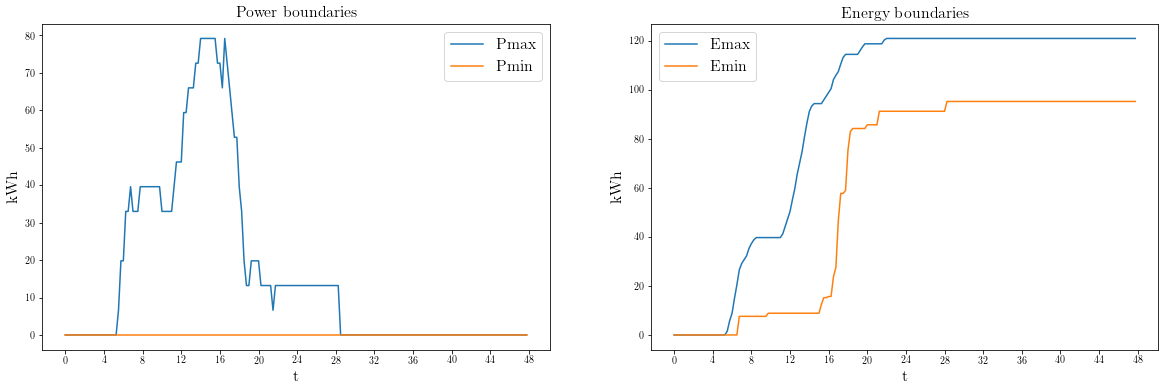

In [7]:
# test EV charging demand function, generate a number of demands and calculate the energy and power boundaries. 
import matplotlib.pyplot as plt
EV_demand = EV_charging_demand_read()
print 'Examples of EV charging demands:',EV_demand[[100],:]
P_max, P_min, E_max, E_min = EV_aggregate_model(EV_demand, 20, 6.6, 0.92, 96, 0.25)

EV_plot_result(P_max, P_min, E_max, E_min, P_optimal=None, E_optimal=None)

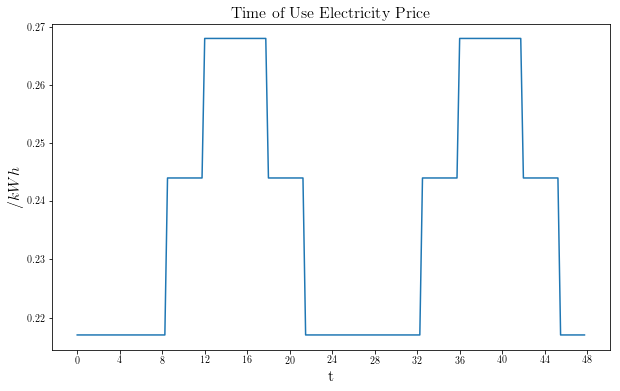

In [49]:
import numpy as np
# define parameters of the planing model
# time interval (in a day)
t_number_inaday = 96;
delta_time = 24.0/t_number_inaday; 

# penalty for unsatisfied charging demands, in $/kWh
Cost_penalty = 10000 

# costs for chargers in US Dollars
Cost_charger = 500.0
Interest = 0.05
Lifetime = 15
Capital_recover_factor = Interest*(1+Interest)**Lifetime/((1+Interest)**Lifetime-1) 

# rated charging power and charging efficiency
P_rated = 7.2 #kw
P_effi = 0.92

# Transformer capacity
Transformer_cap=10**10

# Based load of the system
BaseLoad = np.zeros(t_number_inaday)

# define time of use electricity prices
TOU = np.zeros(t_number_inaday) # this should be time of use
np.put(TOU, np.arange(0,34), 0.217)
np.put(TOU, np.arange(34,48), 0.244)
np.put(TOU, np.arange(48,72), 0.268)
np.put(TOU, np.arange(72,86), 0.244)
np.put(TOU, np.arange(86,96), 0.217)
# time of use prices can be different for commercial/residential/

# EV charging demand
EV_demand = EV_charging_demand_read()
P_ub_aggregate, P_lb_aggregate, E_ub_aggregate, E_lb_aggregate = EV_aggregate_model(EV_demand, 50, P_rated, P_effi, t_number_inaday, delta_time)
# the generated boundaries are in (t_number_inaday*2) * 1 dimention. This is because part of the EVs will park to the next day

plt.rc('text', usetex=True) 
plt.rc('font', family='serif') 
plt.figure(figsize=(10,6))
# Plot trade-off curve.
plt.subplot(111)
plt.plot(np.arange(len(P_ub_aggregate))*delta_time, np.hstack((TOU,TOU)), label="TOU")
plt.xlabel(r't', fontsize=16)
plt.ylabel(r'$/kWh', fontsize=16)
plt.xticks(np.arange(0,49,4))
plt.title('Time of Use Electricity Price', fontsize=16)
plt.show()

status: optimal
optimal value 29720.0812748
x value: 24.0


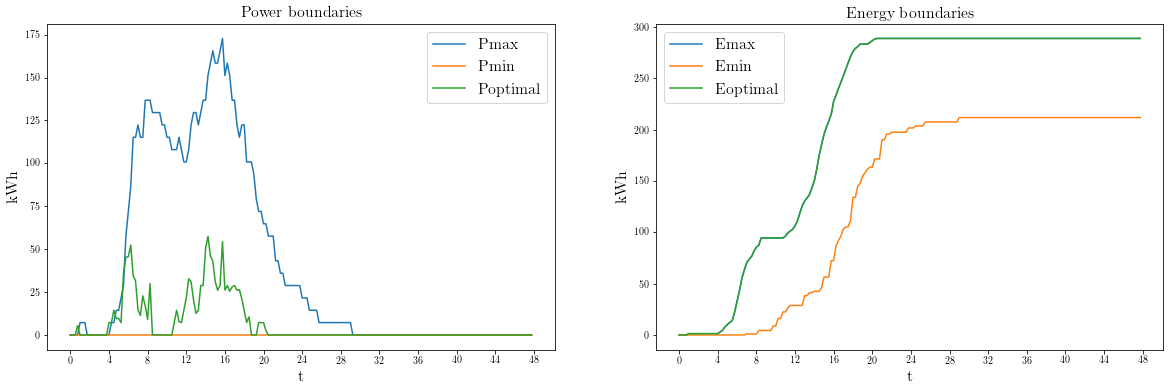

In [50]:
# uncoordinated charging scenario, without interchange 
# a charging spot will only be available when the former vehicle drivers away
import cvxpy as cvx
import numpy as np
import gurobipy 

# Creat decision variables
x = cvx.Int()
P_EV = cvx.Variable(t_number_inaday*2)
# Constriants 
# constraints, domain & aggregate power , the power of the EVs should not violate the amount that EVs can actually accept
constraints = [x >= 0, P_EV >= P_lb_aggregate]

# constraints, Aggregate energy, the commulative energy consumption should satisfy the demands
for temp_t in range(0, t_number_inaday*2):
    constraints += [P_effi*delta_time*cvx.sum_entries(P_EV[0:temp_t]) == E_ub_aggregate[temp_t]]

# constraints, charger number, the EV charging power should not violate the capacity that chargers can actually provide
constraints += [P_ub_aggregate[0:t_number_inaday-1] + P_ub_aggregate[t_number_inaday:-1] <= P_rated*x]

# objective, investment costs + operation costs (electricity costs)
obj = cvx.Minimize(Capital_recover_factor*Cost_charger*x + 365*delta_time*cvx.sum_entries(np.hstack((TOU,TOU))*P_EV))
               
# solve problem.
prob = cvx.Problem(obj, constraints)

# solve the problem, here we adopted the solver gurobi
result = prob.solve(solver="GUROBI", verbose=False)
# result = prob.solve()

# Optimizaiton output
print "status:", prob.status
print "optimal value", prob.value
print "x value:", x.value
# print "P_EV value:", P_EV.value.T

E_optimal=np.zeros(96*2)
for temp_t in range(0, 96*2):
    np.put(E_optimal, temp_t, P_effi*0.25*np.sum(P_EV.value[0:temp_t])) 

# plot results
EV_plot_result(P_ub_aggregate, P_lb_aggregate, E_ub_aggregate, E_lb_aggregate, P_EV.value, E_optimal)

status: optimal
optimal value 28949.3429739
x value: 8.0


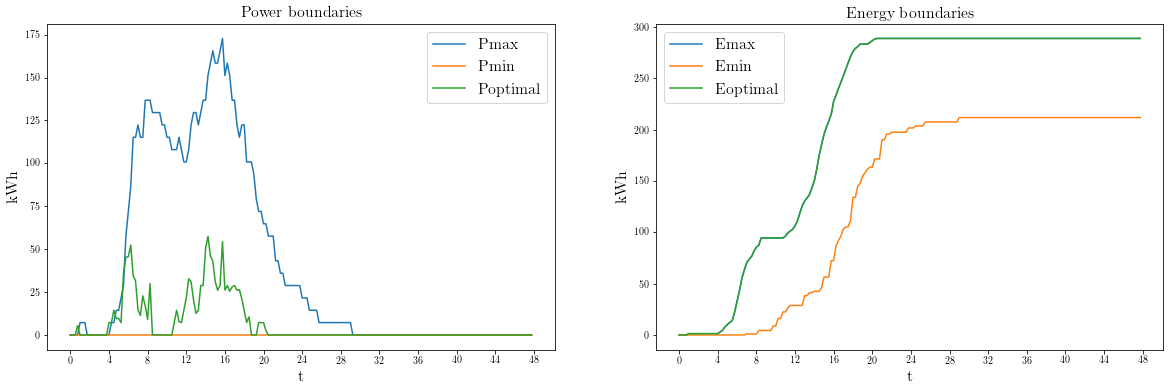

In [51]:
# uncoordinated charging scenario, perfect interchange (no idle time because of fully-charged vehicle parking)
import cvxpy as cvx
import numpy as np
import gurobipy 
# print cvx.installed_solvers() # check the solvers that is installed with cvxp

# Creat decision variables
x = cvx.Int()
P_EV = cvx.Variable(t_number_inaday*2)
# Constriants 
# constraints, domain & aggregate power , the power of the EVs should not violate the amount that EVs can actually accept
constraints = [x >= 0, P_EV >= P_lb_aggregate]

# constraints, Aggregate energy, the commulative energy consumption should satisfy the demands
for temp_t in range(0, t_number_inaday*2):
    constraints += [P_effi*delta_time*cvx.sum_entries(P_EV[0:temp_t]) == E_ub_aggregate[temp_t]]

# constraints, charger number, the EV charging power should not violate the capacity that chargers can actually provide
constraints += [P_EV[0:t_number_inaday-1] + P_EV[t_number_inaday:-1] <= P_rated*x]

# objective, investment costs + operation costs (electricity costs)
obj = cvx.Minimize(Capital_recover_factor*Cost_charger*x + 365*delta_time*cvx.sum_entries(np.hstack((TOU,TOU))*P_EV))
             
# solve problem.
prob = cvx.Problem(obj, constraints)

# solve the problem, here we adopted the solver gurobi
result = prob.solve(solver="GUROBI", verbose=False)
# result = prob.solve()

# Optimizaiton output
print "status:", prob.status
print "optimal value", prob.value
print "x value:", x.value
# print "P_EV value:", P_EV.value.T

E_optimal=np.zeros(96*2)
for temp_t in range(0, 96*2):
    np.put(E_optimal, temp_t, P_effi*0.25*np.sum(P_EV.value[0:temp_t])) 

# plot results
EV_plot_result(P_ub_aggregate, P_lb_aggregate, E_ub_aggregate, E_lb_aggregate, P_EV.value, E_optimal)

status: optimal
optimal value 19782.5122423
x value: 4.0


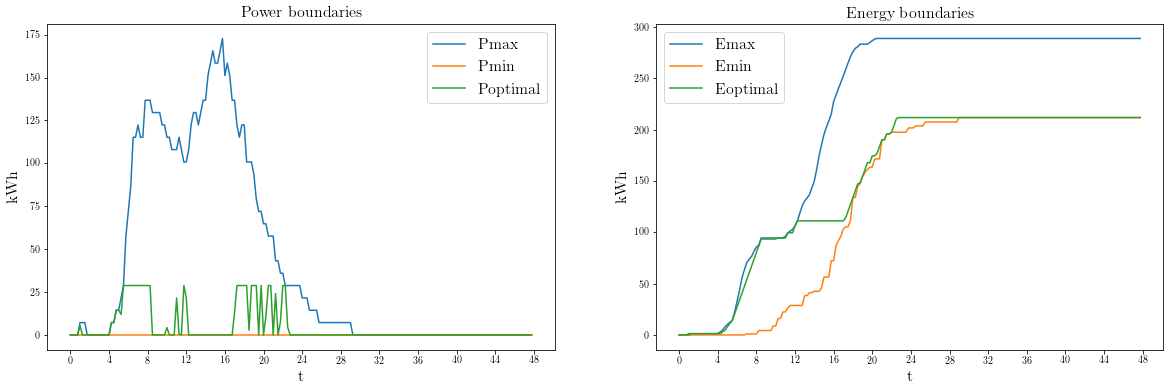

In [65]:
# coordinated charging scenario, perfect interchange (no idle time because of fully-charged vehicle parking)
import cvxpy as cvx
import numpy as np
import gurobipy 
# print cvx.installed_solvers() # check the solvers that is installed with cvxpy

# Creat decision variables
x = cvx.Int()
P_EV = cvx.Variable(t_number_inaday*2)
P_EV_loss = cvx.Variable(t_number_inaday*2)
# Constriants 
# constraints, domain & aggregate power , the power of the EVs should not violate the amount that EVs can actually accept
constraints = [x >= 0, P_EV >= P_lb_aggregate, P_EV <= P_ub_aggregate, P_EV_loss>=0]

# constraints, Aggregate energy, the commulative energy consumption should satisfy the demands
for temp_t in range(0, t_number_inaday*2):
    constraints += [P_effi*delta_time*cvx.sum_entries(P_EV[0:temp_t] + P_EV_loss[0:temp_t]) <= E_ub_aggregate[temp_t]]
    constraints.append(P_effi*delta_time*cvx.sum_entries(P_EV[0:temp_t] + P_EV_loss[0:temp_t]) >= E_lb_aggregate[temp_t])

# constraints, charger number, the EV charging power should not violate the capacity that chargers can actually provide
constraints += [P_EV[0:t_number_inaday-1] + P_EV[t_number_inaday:-1] <= P_rated*x]

# constraints, transformer capacity 
constraints += [P_EV[0:t_number_inaday] + P_EV[t_number_inaday:] + BaseLoad <= Transformer_cap]

# objective, investment costs + operation costs (electricity costs)
obj_function = 365*delta_time*Cost_penalty*cvx.sum_entries(P_EV_loss) #penalty for EV loss
obj_function += Capital_recover_factor*Cost_charger*x
obj_function += 365*delta_time*cvx.sum_entries(np.hstack((TOU,TOU))*P_EV)
obj = cvx.Minimize(obj_function)
               
# solve problem.
prob = cvx.Problem(obj, constraints)

# solve the problem, here we adopted the solver gurobi
result = prob.solve(solver="GUROBI", verbose=False)
# result = prob.solve()

# Optimizaiton output
print "status:", prob.status
print "optimal value", prob.value
print "x value:", x.value
# print "P_EV value:", P_EV.value.T

E_optimal=np.zeros(96*2)
for temp_t in range(0, 96*2):
    np.put(E_optimal, temp_t, P_effi*0.25*np.sum(P_EV.value[0:temp_t])) 

# plot results
# plot results
EV_plot_result(P_ub_aggregate, P_lb_aggregate, E_ub_aggregate, E_lb_aggregate, P_EV.value, E_optimal)